In [107]:
# ==========================================
# 📘 Predict durationMs (User engagement time)
# ==========================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import StackingRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [108]:
# ============================================
# 🧩 Load and prepare dataset
# ============================================
input_path = "cleaned_advanced_events.csv"  # update if needed
df = pd.read_csv(input_path, low_memory=False)

print(f"✅ Loaded: {df.shape}")

✅ Loaded: (109566, 51)


In [109]:
print(df.isnull().sum())

eventType                    0
region                       0
city                         0
timezone                     0
clickX                       0
clickY                       0
scrollPercent                0
durationMs                   0
domLoadTime                  0
fullLoadTime                 0
ttfb                         0
downlink                     0
effectiveType                0
rtt                          0
errorMessage                 0
errorSource                  0
errorLine                    0
errorColumn                  0
clickX_was_missing           0
clickY_was_missing           0
scrollPercent_was_missing    0
screenWidth                  0
screenHeight                 0
aspectRatio                  0
deviceType                   0
url_length                   0
url_depth                    0
is_course_page               0
is_dashboard                 0
browser_simplified           0
lang_main                    0
region_group                 0
scroll_r

In [110]:
# -------------------------
# Define target & features
# -------------------------
target_col = "durationMs"

# drop target and any direct transformations of it
leak_cols = [target_col, "durationMs_log", "durationMs_log1p"]
X = df.drop(columns=[c for c in leak_cols if c in df.columns], errors="ignore")
y = df[target_col]

In [111]:
# -------------------------
# Train-test split
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [112]:
# -------------------------
# Scaling numeric features (optional)
# -------------------------
num_cols = X_train.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [113]:
# -------------------------
# Train models
# -------------------------
models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=1.0, random_state=42),
    "Lasso": Lasso(alpha=0.001, random_state=42),
    "ElasticNet": ElasticNet(alpha=0.001, l1_ratio=0.5, random_state=42),
    # "Huber": HuberRegressor(epsilon=1.35), # get minus R2 score
    "ExtraTrees": ExtraTreesRegressor(
        n_estimators=200, max_depth=None, random_state=42, n_jobs=-1
    ),
    # "AdaBoost": AdaBoostRegressor(
    #     n_estimators=200, learning_rate=0.05, random_state=42
    # ), # get minus R2 score
    # "SVR": SVR(C=10, kernel="rbf", gamma="scale"), # get minus R2 score
    # "KernelRidge": KernelRidge(alpha=1.0, kernel="rbf"), # not enough memory 50GB
    "MLP": MLPRegressor(hidden_layer_sizes=(128, 64), learning_rate_init=0.001, max_iter=300, random_state=42),
    "RandomForest": RandomForestRegressor(
        n_estimators=150, max_depth=20, random_state=42, n_jobs=-1
    ),
    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42
    ),
    "XGBoost": XGBRegressor(
        n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42, n_jobs=-1
    ),
    "LightGBM": LGBMRegressor(
        n_estimators=300, learning_rate=0.05, max_depth=-1, random_state=42, n_jobs=-1
    ),
}

estimators = [
    ("rf", models["RandomForest"]),
    ("xgb", models["XGBoost"]),
    ("lgbm", models["LightGBM"]),
    ("ridge", models["Ridge"]),
]
stack = StackingRegressor(
    estimators=estimators,
    final_estimator=GradientBoostingRegressor(
        n_estimators=150, learning_rate=0.05, max_depth=3, random_state=42
    ),
    n_jobs=-1
)
models["StackedEnsemble"] = stack

results = []
for name, model in models.items():
    print(f"\nTraining {name} ...")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = root_mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    results.append((name, mae, rmse, r2))
    print(f"{name} => MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}")

results_df = pd.DataFrame(results, columns=["Model", "MAE", "RMSE", "R2"]).sort_values("R2", ascending=False)
print("\n🏁 Model Performance Ranking:")
print(results_df)


Training Linear ...
Linear => MAE: 463031.71, RMSE: 1098235.39, R2: 0.1607

Training Ridge ...
Ridge => MAE: 462967.78, RMSE: 1098230.06, R2: 0.1607

Training Lasso ...
Lasso => MAE: 462955.55, RMSE: 1098315.72, R2: 0.1606

Training ElasticNet ...
ElasticNet => MAE: 461966.52, RMSE: 1098317.53, R2: 0.1606

Training ExtraTrees ...
ExtraTrees => MAE: 233700.99, RMSE: 904770.64, R2: 0.4303

Training MLP ...
MLP => MAE: 299216.62, RMSE: 1013046.26, R2: 0.2858

Training RandomForest ...
RandomForest => MAE: 234957.80, RMSE: 905834.95, R2: 0.4290

Training GradientBoosting ...
GradientBoosting => MAE: 295847.12, RMSE: 949990.39, R2: 0.3720

Training XGBoost ...
XGBoost => MAE: 274972.26, RMSE: 919558.08, R2: 0.4116

Training LightGBM ...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 47

In [114]:
# -------------------------
# Model comparison
# -------------------------
res_df = pd.DataFrame(results, columns=["Model", "MAE", "RMSE", "R2"])
print("\n=== Model Comparison ===")
print(res_df)


=== Model Comparison ===
               Model            MAE          RMSE        R2
10   StackedEnsemble  237181.250933  9.022086e+05  0.433569
9           LightGBM  249787.149368  9.027424e+05  0.432899
4         ExtraTrees  233700.990797  9.047706e+05  0.430347
6       RandomForest  234957.795181  9.058350e+05  0.429006
8            XGBoost  274972.264725  9.195581e+05  0.411575
7   GradientBoosting  295847.115121  9.499904e+05  0.371983
5                MLP  299216.623329  1.013046e+06  0.285846
1              Ridge  462967.775357  1.098230e+06  0.160695
0             Linear  463031.713670  1.098235e+06  0.160687
2              Lasso  462955.553836  1.098316e+06  0.160564
3         ElasticNet  461966.523270  1.098318e+06  0.160561


In [115]:
# -------------------------
# Feature Importance (LightGBM)
# -------------------------
best_model_name = res_df.sort_values("R2", ascending=False)["Model"].iloc[0]
best_model = models[best_model_name]
print(f"\nBest model: {best_model_name}")

if hasattr(best_model, "feature_importances_"):
    importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
    top_features = importances.sort_values(ascending=False).head(20)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_features.values, y=top_features.index)
    plt.title(f"Top 20 Features - {best_model_name}")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()


Best model: StackedEnsemble


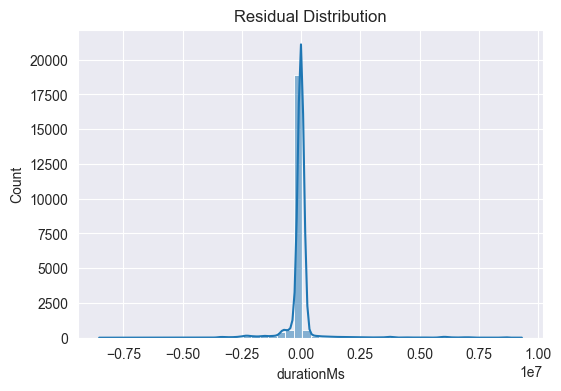

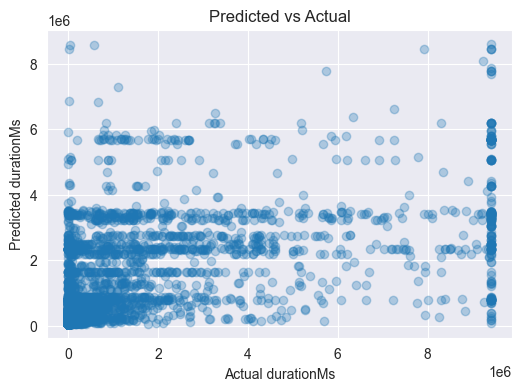

In [116]:
# -------------------------
# Residual analysis
# -------------------------
y_pred = best_model.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(6, 4))
sns.histplot(residuals, bins=50, kde=True)
plt.title("Residual Distribution")
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual durationMs")
plt.ylabel("Predicted durationMs")
plt.title("Predicted vs Actual")
plt.show()

In [117]:
# -------------------------
# Save best model predictions
# -------------------------
output_df = X_test.copy()
output_df["actual_durationMs"] = y_test
output_df["predicted_durationMs"] = y_pred
output_df.to_csv("model_results_durationMs.csv", index=False)
print("\n✅ Saved predictions → model_results_durationMs.csv")


✅ Saved predictions → model_results_durationMs.csv
